In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy.optimize import fsolve
from scipy import integrate
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Constants for ACI 318-19 (SI Units)
class ACIConstants:
    """ACI 318-19 Constants in SI Units"""
    
    # Material strength reduction factors (φ factors)
    PHI_FLEXURE = 0.9          # Flexure (tension-controlled)
    PHI_SHEAR = 0.75           # Shear and torsion
    PHI_COMPRESSION = 0.65     # Compression (spiral)
    PHI_COMPRESSION_TIED = 0.65 # Compression (tied)
    
    # Concrete parameters
    BETA1_FC_28 = 0.85         # β₁ for f'c ≤ 28 MPa
    BETA1_REDUCTION = 0.05     # Reduction per 7 MPa above 28 MPa
    EPSILON_CU = 0.003         # Ultimate concrete strain
    
    # Steel parameters
    FY_MIN = 280               # Minimum yield strength (MPa)
    FY_MAX = 550               # Maximum yield strength (MPa)
    ES = 200000                # Steel modulus of elasticity (MPa)
    
    # Load factors (LRFD)
    GAMMA_D = 1.2              # Dead load factor
    GAMMA_L = 1.6              # Live load factor
    GAMMA_W = 1.0              # Wind load factor
    
    # Minimum reinforcement ratios
    RHO_MIN_TENSION = 0.0018   # Minimum tension reinforcement ratio
    RHO_MAX_TENSION = 0.025    # Maximum tension reinforcement ratio

print("✅ Libraries imported successfully!")
print("✅ ACI 318-19 constants defined!")
print(f"Material factors: φ_flexure = {ACIConstants.PHI_FLEXURE}, φ_shear = {ACIConstants.PHI_SHEAR}")
print(f"Load factors: γ_D = {ACIConstants.GAMMA_D}, γ_L = {ACIConstants.GAMMA_L}")


✅ Libraries imported successfully!
✅ ACI 318-19 constants defined!
Material factors: φ_flexure = 0.9, φ_shear = 0.75
Load factors: γ_D = 1.2, γ_L = 1.6


In [2]:
class BeamAnalyzer:
    """
    Comprehensive beam analysis class for calculating shear forces and bending moments
    Supports various loading conditions and beam configurations
    """
    
    def __init__(self, length, supports='simply_supported'):
        """
        Initialize beam analyzer
        
        Parameters:
        -----------
        length : float
            Beam length in meters
        supports : str
            Support type: 'simply_supported', 'cantilever', 'fixed_fixed'
        """
        self.length = length
        self.supports = supports
        self.loads = []
        
    def add_point_load(self, magnitude, position):
        """Add point load to beam"""
        self.loads.append({
            'type': 'point',
            'magnitude': magnitude,  # kN
            'position': position     # m from left support
        })
        
    def add_distributed_load(self, magnitude, start=0, end=None):
        """Add distributed load to beam"""
        if end is None:
            end = self.length
        self.loads.append({
            'type': 'distributed',
            'magnitude': magnitude,  # kN/m
            'start': start,         # m from left support
            'end': end              # m from left support
        })
        
    def add_moment(self, magnitude, position):
        """Add applied moment to beam"""
        self.loads.append({
            'type': 'moment',
            'magnitude': magnitude,  # kN⋅m
            'position': position     # m from left support
        })
    
    def calculate_reactions(self):
        """Calculate support reactions"""
        if self.supports == 'simply_supported':
            return self._reactions_simply_supported()
        elif self.supports == 'cantilever':
            return self._reactions_cantilever()
        elif self.supports == 'fixed_fixed':
            return self._reactions_fixed_fixed()
            
    def _reactions_simply_supported(self):
        """Calculate reactions for simply supported beam"""
        R_A = 0  # Vertical reaction at left support
        R_B = 0  # Vertical reaction at right support
        
        # Sum of vertical forces = 0
        for load in self.loads:
            if load['type'] == 'point':
                R_A += load['magnitude'] * (self.length - load['position']) / self.length
                R_B += load['magnitude'] * load['position'] / self.length
            elif load['type'] == 'distributed':
                load_length = load['end'] - load['start']
                total_load = load['magnitude'] * load_length
                centroid = load['start'] + load_length / 2
                R_A += total_load * (self.length - centroid) / self.length
                R_B += total_load * centroid / self.length
                
        return {'R_A': R_A, 'R_B': R_B}
    
    def _reactions_cantilever(self):
        """Calculate reactions for cantilever beam"""
        R_A = 0  # Vertical reaction at fixed support
        M_A = 0  # Moment reaction at fixed support
        
        for load in self.loads:
            if load['type'] == 'point':
                R_A += load['magnitude']
                M_A += load['magnitude'] * load['position']
            elif load['type'] == 'distributed':
                load_length = load['end'] - load['start']
                total_load = load['magnitude'] * load_length
                centroid = load['start'] + load_length / 2
                R_A += total_load
                M_A += total_load * centroid
            elif load['type'] == 'moment':
                M_A += load['magnitude']
                
        return {'R_A': R_A, 'M_A': M_A}
    
    def _reactions_fixed_fixed(self):
        """Calculate reactions for fixed-fixed beam (simplified analysis)"""
        # This is a simplified analysis - for more complex cases, use matrix methods
        total_load = 0
        moment_about_center = 0
        
        for load in self.loads:
            if load['type'] == 'point':
                total_load += load['magnitude']
                moment_about_center += load['magnitude'] * (load['position'] - self.length/2)
            elif load['type'] == 'distributed':
                load_length = load['end'] - load['start']
                load_total = load['magnitude'] * load_length
                centroid = load['start'] + load_length / 2
                total_load += load_total
                moment_about_center += load_total * (centroid - self.length/2)
        
        # Simplified reactions (assuming symmetry for uniform loads)
        R_A = R_B = total_load / 2
        M_A = M_B = 0  # Simplified assumption
        
        return {'R_A': R_A, 'R_B': R_B, 'M_A': M_A, 'M_B': M_B}
    
    def calculate_shear_force(self, x):
        """Calculate shear force at position x"""
        reactions = self.calculate_reactions()
        V = 0
        
        if self.supports == 'simply_supported':
            V = reactions['R_A']
        elif self.supports == 'cantilever':
            V = reactions['R_A']
        elif self.supports == 'fixed_fixed':
            V = reactions['R_A']
            
        # Subtract loads to the left of position x
        for load in self.loads:
            if load['type'] == 'point' and load['position'] <= x:
                V -= load['magnitude']
            elif load['type'] == 'distributed':
                if x >= load['end']:
                    # Entire distributed load is to the left
                    V -= load['magnitude'] * (load['end'] - load['start'])
                elif x > load['start']:
                    # Partial distributed load is to the left
                    V -= load['magnitude'] * (x - load['start'])
                    
        return V
    
    def calculate_bending_moment(self, x):
        """Calculate bending moment at position x"""
        reactions = self.calculate_reactions()
        M = 0
        
        if self.supports == 'simply_supported':
            M = reactions['R_A'] * x
        elif self.supports == 'cantilever':
            M = reactions['R_A'] * x - reactions['M_A']
        elif self.supports == 'fixed_fixed':
            M = reactions['R_A'] * x + reactions.get('M_A', 0)
            
        # Add moments from loads to the left of position x
        for load in self.loads:
            if load['type'] == 'point' and load['position'] <= x:
                M -= load['magnitude'] * (x - load['position'])
            elif load['type'] == 'distributed':
                if x >= load['end']:
                    # Entire distributed load is to the left
                    load_length = load['end'] - load['start']
                    total_load = load['magnitude'] * load_length
                    centroid = load['start'] + load_length / 2
                    M -= total_load * (x - centroid)
                elif x > load['start']:
                    # Partial distributed load is to the left
                    partial_length = x - load['start']
                    partial_load = load['magnitude'] * partial_length
                    partial_centroid = load['start'] + partial_length / 2
                    M -= partial_load * (x - partial_centroid)
            elif load['type'] == 'moment' and load['position'] <= x:
                M += load['magnitude']
                
        return M
    
    def get_analysis_points(self, num_points=100):
        """Generate analysis points along beam length"""
        x_values = np.linspace(0, self.length, num_points)
        shear_values = [self.calculate_shear_force(x) for x in x_values]
        moment_values = [self.calculate_bending_moment(x) for x in x_values]
        
        return x_values, shear_values, moment_values

print("✅ BeamAnalyzer class created successfully!")
print("Features: Point loads, distributed loads, applied moments")
print("Support types: Simply supported, cantilever, fixed-fixed")


✅ BeamAnalyzer class created successfully!
Features: Point loads, distributed loads, applied moments
Support types: Simply supported, cantilever, fixed-fixed


In [3]:
class ACIBeamDesigner:
    """
    ACI 318-19 Concrete Beam Design Calculator
    Performs flexural and shear design according to ACI 318-19 standards
    All calculations in SI units (MPa, mm, kN, m)
    """
    
    def __init__(self, fc_prime=25, fy=420, beam_width=300, beam_height=600, cover=40):
        """
        Initialize beam designer with material and geometric properties
        
        Parameters:
        -----------
        fc_prime : float
            Concrete compressive strength (MPa)
        fy : float
            Steel yield strength (MPa)
        beam_width : float
            Beam width (mm)
        beam_height : float
            Beam height (mm)
        cover : float
            Concrete cover to reinforcement (mm)
        """
        self.fc_prime = fc_prime
        self.fy = fy
        self.b = beam_width
        self.h = beam_height
        self.cover = cover
        self.d = beam_height - cover - 10  # Effective depth (assuming 20mm bar diameter)
        
        # Calculate material properties
        self.beta1 = self._calculate_beta1()
        self.ec = self._calculate_ec()
        
    def _calculate_beta1(self):
        """Calculate β₁ factor per ACI 318-19"""
        if self.fc_prime <= 28:
            return ACIConstants.BETA1_FC_28
        else:
            reduction = (self.fc_prime - 28) / 7 * ACIConstants.BETA1_REDUCTION
            return max(ACIConstants.BETA1_FC_28 - reduction, 0.65)
    
    def _calculate_ec(self):
        """Calculate concrete modulus of elasticity (MPa)"""
        return 4700 * np.sqrt(self.fc_prime)
    
    def calculate_min_reinforcement(self):
        """Calculate minimum tension reinforcement per ACI 318-19"""
        # Per ACI 318-19 Section 9.6.1.2
        As_min_1 = 0.25 * np.sqrt(self.fc_prime) / self.fy * self.b * self.d
        As_min_2 = 1.4 * self.b * self.d / self.fy
        
        return max(As_min_1, As_min_2)
    
    def calculate_max_reinforcement(self):
        """Calculate maximum tension reinforcement per ACI 318-19"""
        # For tension-controlled sections (φ = 0.9)
        # c/d ≤ 0.375 for Grade 420 steel
        c_max = 0.375 * self.d
        a_max = self.beta1 * c_max
        As_max = 0.85 * self.fc_prime * self.b * a_max / self.fy
        
        return As_max
    
    def design_flexural_reinforcement(self, Mu):
        """
        Design flexural reinforcement for given ultimate moment
        
        Parameters:
        -----------
        Mu : float
            Ultimate moment (kN⋅m)
            
        Returns:
        --------
        dict : Design results including As_required, rho, etc.
        """
        # Convert moment to N⋅mm
        Mu_Nmm = Mu * 1e6
        
        # Calculate required reinforcement using simplified method
        # Assume internal lever arm = 0.9d as first approximation
        z = 0.9 * self.d
        As_required = Mu_Nmm / (ACIConstants.PHI_FLEXURE * self.fy * z)
        
        # Iterative solution for more accurate design
        def moment_capacity(As):
            # Calculate neutral axis depth
            c = As * self.fy / (0.85 * self.fc_prime * self.b * self.beta1)
            a = self.beta1 * c
            
            # Check if tension-controlled
            epsilon_t = ACIConstants.EPSILON_CU * (self.d - c) / c
            
            if epsilon_t >= 0.005:  # Tension-controlled
                phi = ACIConstants.PHI_FLEXURE
            elif epsilon_t >= 0.002:  # Transition zone
                phi = 0.65 + (epsilon_t - 0.002) * (0.25 / 0.003)
            else:  # Compression-controlled
                phi = ACIConstants.PHI_COMPRESSION
                
            # Calculate moment capacity
            Mn = As * self.fy * (self.d - a/2)
            return phi * Mn - Mu_Nmm
        
        # Solve iteratively
        try:
            As_accurate = fsolve(moment_capacity, As_required)[0]
        except:
            As_accurate = As_required
            
        # Check minimum and maximum limits
        As_min = self.calculate_min_reinforcement()
        As_max = self.calculate_max_reinforcement()
        
        As_final = max(As_min, min(As_accurate, As_max))
        
        # Calculate reinforcement ratio
        rho = As_final / (self.b * self.d)
        
        # Calculate actual moment capacity
        c_actual = As_final * self.fy / (0.85 * self.fc_prime * self.b * self.beta1)
        a_actual = self.beta1 * c_actual
        epsilon_t_actual = ACIConstants.EPSILON_CU * (self.d - c_actual) / c_actual
        
        if epsilon_t_actual >= 0.005:
            phi_actual = ACIConstants.PHI_FLEXURE
            section_type = "Tension-controlled"
        elif epsilon_t_actual >= 0.002:
            phi_actual = 0.65 + (epsilon_t_actual - 0.002) * (0.25 / 0.003)
            section_type = "Transition"
        else:
            phi_actual = ACIConstants.PHI_COMPRESSION
            section_type = "Compression-controlled"
            
        Mn_actual = As_final * self.fy * (self.d - a_actual/2)
        phi_Mn = phi_actual * Mn_actual / 1e6  # Convert to kN⋅m
        
        return {
            'As_required': As_final,  # mm²
            'As_min': As_min,        # mm²
            'As_max': As_max,        # mm²
            'rho': rho,              # Reinforcement ratio
            'c': c_actual,           # Neutral axis depth (mm)
            'a': a_actual,           # Equivalent rectangular stress block depth (mm)
            'epsilon_t': epsilon_t_actual,  # Tensile strain
            'phi': phi_actual,       # Strength reduction factor
            'section_type': section_type,
            'Mn': Mn_actual / 1e6,   # Nominal moment capacity (kN⋅m)
            'phi_Mn': phi_Mn,        # Design moment capacity (kN⋅m)
            'utilization': Mu / phi_Mn  # Moment utilization ratio
        }
    
    def design_shear_reinforcement(self, Vu):
        """
        Design shear reinforcement for given ultimate shear
        
        Parameters:
        -----------
        Vu : float
            Ultimate shear force (kN)
            
        Returns:
        --------
        dict : Shear design results
        """
        # Convert shear to N
        Vu_N = Vu * 1000
        
        # Calculate concrete shear capacity (simplified)
        # Vc = 0.17 * sqrt(f'c) * bw * d (in N)
        Vc = 0.17 * np.sqrt(self.fc_prime) * self.b * self.d
        phi_Vc = ACIConstants.PHI_SHEAR * Vc
        
        # Check if shear reinforcement is required
        if Vu_N <= phi_Vc:
            # No shear reinforcement required, but minimum may be needed
            stirrup_requirement = "Minimum stirrups required"
            Vs_required = 0
            s_max = min(self.d/2, 600)  # Maximum spacing (mm)
        else:
            # Shear reinforcement required
            Vs_required = Vu_N / ACIConstants.PHI_SHEAR - Vc
            stirrup_requirement = "Shear reinforcement required"
            
            # Maximum allowable Vs
            Vs_max = 0.67 * np.sqrt(self.fc_prime) * self.b * self.d
            
            if Vs_required > Vs_max:
                stirrup_requirement = "Section too small - increase dimensions"
                
            # Calculate stirrup spacing (assuming 2-leg 10mm stirrups)
            Av = 2 * np.pi * (10/2)**2  # Area of 2-leg 10mm stirrups (mm²)
            s_required = Av * self.fy / (Vs_required / self.d)  # Required spacing (mm)
            s_max = min(self.d/2, 600)  # Maximum spacing (mm)
            
        # Minimum shear reinforcement
        # Av_min/s = 0.35 * bw / fy (per mm length)
        s_min_shear = (2 * np.pi * (10/2)**2) / (0.35 * self.b / self.fy)
        
        return {
            'Vc': Vc / 1000,          # Concrete shear capacity (kN)
            'phi_Vc': phi_Vc / 1000,  # Design concrete shear capacity (kN)
            'Vs_required': Vs_required / 1000,  # Required steel shear capacity (kN)
            'Vs_max': Vs_max / 1000,  # Maximum allowable steel shear capacity (kN)
            'stirrup_requirement': stirrup_requirement,
            's_required': s_required if Vs_required > 0 else s_min_shear,  # Required spacing (mm)
            's_max': s_max,           # Maximum spacing (mm)
            'utilization': Vu / (phi_Vc / 1000) if phi_Vc > 0 else float('inf')
        }
    
    def select_reinforcement_bars(self, As_required):
        """
        Select reinforcement bars to provide required area
        
        Parameters:
        -----------
        As_required : float
            Required reinforcement area (mm²)
            
        Returns:
        --------
        list : Possible bar combinations
        """
        # Standard bar areas (mm²)
        bar_areas = {
            10: 78.5,
            12: 113.1,
            16: 201.1,
            20: 314.2,
            25: 490.9,
            32: 804.2,
            40: 1256.6
        }
        
        combinations = []
        
        for diameter, area in bar_areas.items():
            for num_bars in range(2, 11):  # 2 to 10 bars
                total_area = num_bars * area
                if 0.95 * As_required <= total_area <= 1.5 * As_required:
                    combinations.append({
                        'bars': f"{num_bars}Ø{diameter}",
                        'diameter': diameter,
                        'number': num_bars,
                        'area_provided': total_area,
                        'area_ratio': total_area / As_required,
                        'spacing': (self.b - 2*self.cover) / (num_bars - 1) if num_bars > 1 else 0
                    })
        
        # Sort by efficiency (closest to required area)
        combinations.sort(key=lambda x: abs(x['area_ratio'] - 1.0))
        
        return combinations[:5]  # Return top 5 options

print("✅ ACIBeamDesigner class created successfully!")
print("Features: Flexural design, shear design, reinforcement selection")
print("Standards: ACI 318-19 with SI units")


✅ ACIBeamDesigner class created successfully!
Features: Flexural design, shear design, reinforcement selection
Standards: ACI 318-19 with SI units


In [4]:
class BeamPlotter:
    """
    Advanced plotting tools for beam analysis and design visualization
    Creates professional engineering diagrams and charts
    """
    
    @staticmethod
    def plot_beam_diagrams(analyzer, title="Beam Analysis", figsize=(14, 10)):
        """
        Create comprehensive beam diagrams including loading, SFD, and BMD
        
        Parameters:
        -----------
        analyzer : BeamAnalyzer
            Configured beam analyzer object
        title : str
            Plot title
        figsize : tuple
            Figure size (width, height)
        """
        # Get analysis data
        x, V, M = analyzer.get_analysis_points(200)
        reactions = analyzer.calculate_reactions()
        
        # Create subplots
        fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)
        fig.suptitle(title, fontsize=16, fontweight='bold')
        
        # 1. Beam Loading Diagram
        ax1 = axes[0]
        ax1.set_title('Loading Diagram', fontweight='bold')
        
        # Draw beam
        beam_y = 0
        ax1.plot([0, analyzer.length], [beam_y, beam_y], 'k-', linewidth=4, label='Beam')
        
        # Draw supports
        if analyzer.supports == 'simply_supported':
            # Left support (pin)
            ax1.plot(0, beam_y, 'ko', markersize=8)
            ax1.plot([0, 0], [beam_y-0.3, beam_y], 'k-', linewidth=2)
            ax1.plot([-0.1, 0.1], [beam_y-0.3, beam_y-0.3], 'k-', linewidth=2)
            
            # Right support (roller)
            ax1.plot(analyzer.length, beam_y, 'ko', markersize=8)
            circle = plt.Circle((analyzer.length, beam_y-0.15), 0.1, fill=False, linewidth=2)
            ax1.add_patch(circle)
            ax1.plot([analyzer.length-0.1, analyzer.length+0.1], [beam_y-0.3, beam_y-0.3], 'k-', linewidth=2)
        
        # Draw loads
        for load in analyzer.loads:
            if load['type'] == 'point':
                # Point load arrow
                ax1.annotate('', xy=(load['position'], beam_y), 
                           xytext=(load['position'], beam_y + 0.5),
                           arrowprops=dict(arrowstyle='->', lw=2, color='red'))
                ax1.text(load['position'], beam_y + 0.6, f"{load['magnitude']:.1f} kN", 
                        ha='center', fontweight='bold', color='red')
                        
            elif load['type'] == 'distributed':
                # Distributed load
                x_dist = np.linspace(load['start'], load['end'], 20)
                y_dist = np.full_like(x_dist, beam_y + 0.4)
                ax1.plot(x_dist, y_dist, 'b-', linewidth=3, label=f"{load['magnitude']:.1f} kN/m")
                
                # Arrows for distributed load
                for xi in x_dist[::3]:
                    ax1.annotate('', xy=(xi, beam_y), xytext=(xi, beam_y + 0.4),
                               arrowprops=dict(arrowstyle='->', lw=1, color='blue'))
        
        # Add reaction labels
        if 'R_A' in reactions:
            ax1.annotate('', xy=(0, beam_y-0.1), xytext=(0, beam_y-0.4),
                        arrowprops=dict(arrowstyle='->', lw=2, color='green'))
            ax1.text(0, beam_y-0.5, f"R_A = {reactions['R_A']:.1f} kN", 
                    ha='center', fontweight='bold', color='green')
        if 'R_B' in reactions:
            ax1.annotate('', xy=(analyzer.length, beam_y-0.1), 
                        xytext=(analyzer.length, beam_y-0.4),
                        arrowprops=dict(arrowstyle='->', lw=2, color='green'))
            ax1.text(analyzer.length, beam_y-0.5, f"R_B = {reactions['R_B']:.1f} kN", 
                    ha='center', fontweight='bold', color='green')
        
        ax1.set_ylim(-1, 1)
        ax1.set_ylabel('Loading')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # 2. Shear Force Diagram
        ax2 = axes[1]
        ax2.set_title('Shear Force Diagram (SFD)', fontweight='bold')
        ax2.plot(x, V, 'b-', linewidth=2.5, label='Shear Force')
        ax2.fill_between(x, V, alpha=0.3, color='blue')
        ax2.axhline(y=0, color='k', linestyle='-', alpha=0.5)
        ax2.set_ylabel('Shear Force (kN)')
        ax2.grid(True, alpha=0.3)
        
        # Mark maximum and minimum values
        V_max = max(V)
        V_min = min(V)
        if abs(V_max) > abs(V_min):
            max_idx = V.index(V_max)
            ax2.plot(x[max_idx], V_max, 'ro', markersize=8)
            ax2.text(x[max_idx], V_max + 0.05*abs(V_max), f'V_max = {V_max:.1f} kN', 
                    ha='center', fontweight='bold', color='red')
        else:
            min_idx = V.index(V_min)
            ax2.plot(x[min_idx], V_min, 'ro', markersize=8)
            ax2.text(x[min_idx], V_min - 0.05*abs(V_min), f'V_min = {V_min:.1f} kN', 
                    ha='center', fontweight='bold', color='red')
        
        # 3. Bending Moment Diagram
        ax3 = axes[2]
        ax3.set_title('Bending Moment Diagram (BMD)', fontweight='bold')
        ax3.plot(x, M, 'r-', linewidth=2.5, label='Bending Moment')
        ax3.fill_between(x, M, alpha=0.3, color='red')
        ax3.axhline(y=0, color='k', linestyle='-', alpha=0.5)
        ax3.set_ylabel('Bending Moment (kN⋅m)')
        ax3.grid(True, alpha=0.3)
        
        # Mark maximum moment
        M_max = max(M)
        M_min = min(M)
        if abs(M_max) > abs(M_min):
            max_idx = M.index(M_max)
            ax3.plot(x[max_idx], M_max, 'ko', markersize=8)
            ax3.text(x[max_idx], M_max + 0.05*abs(M_max), f'M_max = {M_max:.1f} kN⋅m', 
                    ha='center', fontweight='bold', color='black')
        else:
            min_idx = M.index(M_min)
            ax3.plot(x[min_idx], M_min, 'ko', markersize=8)
            ax3.text(x[min_idx], M_min - 0.05*abs(M_min), f'M_min = {M_min:.1f} kN⋅m', 
                    ha='center', fontweight='bold', color='black')
        
        # 4. Beam Cross-section (schematic)
        ax4 = axes[3]
        ax4.set_title('Beam Span', fontweight='bold')
        ax4.plot([0, analyzer.length], [0, 0], 'k-', linewidth=6)
        
        # Add dimension line
        ax4.annotate('', xy=(0, -0.1), xytext=(analyzer.length, -0.1),
                    arrowprops=dict(arrowstyle='<->', lw=1))
        ax4.text(analyzer.length/2, -0.15, f'L = {analyzer.length:.1f} m', 
                ha='center', fontweight='bold')
        
        # Mark critical points
        for i, xi in enumerate(x[::20]):  # Every 20th point
            ax4.plot([xi, xi], [-0.05, 0.05], 'k-', alpha=0.5)
            if i % 5 == 0:  # Label every 5th mark
                ax4.text(xi, 0.08, f'{xi:.1f}', ha='center', fontsize=8)
        
        ax4.set_ylim(-0.2, 0.15)
        ax4.set_xlabel('Distance along beam (m)')
        ax4.set_ylabel('Position')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    @staticmethod
    def plot_interactive_diagrams(analyzer, title="Interactive Beam Analysis"):
        """
        Create interactive Plotly diagrams for beam analysis
        """
        x, V, M = analyzer.get_analysis_points(200)
        reactions = analyzer.calculate_reactions()
        
        # Create subplots
        fig = make_subplots(
            rows=3, cols=1,
            subplot_titles=('Loading Diagram', 'Shear Force Diagram', 'Bending Moment Diagram'),
            vertical_spacing=0.08
        )
        
        # Loading diagram (simplified)
        fig.add_trace(
            go.Scatter(x=[0, analyzer.length], y=[0, 0], 
                      mode='lines', name='Beam', line=dict(color='black', width=6)),
            row=1, col=1
        )
        
        # Shear force diagram
        fig.add_trace(
            go.Scatter(x=x, y=V, fill='tozeroy', name='Shear Force', 
                      line=dict(color='blue', width=2)),
            row=2, col=1
        )
        
        # Bending moment diagram
        fig.add_trace(
            go.Scatter(x=x, y=M, fill='tozeroy', name='Bending Moment', 
                      line=dict(color='red', width=2)),
            row=3, col=1
        )
        
        # Update layout
        fig.update_layout(
            title=title,
            height=800,
            showlegend=True
        )
        
        fig.update_xaxes(title_text="Distance along beam (m)", row=3, col=1)
        fig.update_yaxes(title_text="Load", row=1, col=1)
        fig.update_yaxes(title_text="Shear Force (kN)", row=2, col=1)
        fig.update_yaxes(title_text="Bending Moment (kN⋅m)", row=3, col=1)
        
        return fig
    
    @staticmethod
    def plot_design_summary(designer, flexural_results, shear_results, figsize=(12, 8)):
        """
        Create design summary visualization
        """
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('ACI 318-19 Beam Design Summary', fontsize=16, fontweight='bold')
        
        # 1. Cross-section diagram
        ax1 = axes[0, 0]
        ax1.set_title('Beam Cross-Section', fontweight='bold')
        
        # Draw beam outline
        beam_rect = Rectangle((0, 0), designer.b, designer.h, 
                            linewidth=2, edgecolor='black', facecolor='lightgray', alpha=0.7)
        ax1.add_patch(beam_rect)
        
        # Draw reinforcement
        As_required = flexural_results['As_required']
        bar_options = designer.select_reinforcement_bars(As_required)
        if bar_options:
            best_option = bar_options[0]
            num_bars = best_option['number']
            bar_dia = best_option['diameter']
            
            # Position bars
            clear_width = designer.b - 2 * designer.cover
            if num_bars > 1:
                spacing = clear_width / (num_bars - 1)
                for i in range(num_bars):
                    x_pos = designer.cover + i * spacing
                    y_pos = designer.cover
                    circle = plt.Circle((x_pos, y_pos), bar_dia/2, color='darkred')
                    ax1.add_patch(circle)
            
            ax1.text(designer.b/2, designer.h + 20, f'Reinforcement: {best_option["bars"]}', 
                    ha='center', fontweight='bold')
        
        # Add dimensions
        ax1.text(designer.b/2, -30, f'b = {designer.b} mm', ha='center', fontweight='bold')
        ax1.text(-40, designer.h/2, f'h = {designer.h} mm', va='center', rotation=90, fontweight='bold')
        ax1.text(-40, designer.d, f'd = {designer.d} mm', va='center', rotation=90, color='blue')
        
        ax1.set_xlim(-60, designer.b + 20)
        ax1.set_ylim(-40, designer.h + 40)
        ax1.set_aspect('equal')
        ax1.axis('off')
        
        # 2. Moment capacity chart
        ax2 = axes[0, 1]
        ax2.set_title('Moment Capacity', fontweight='bold')
        
        moments = ['M_u (Applied)', 'φM_n (Capacity)']
        values = [flexural_results['phi_Mn'] * flexural_results['utilization'], 
                 flexural_results['phi_Mn']]
        colors = ['red', 'green']
        
        bars = ax2.bar(moments, values, color=colors, alpha=0.7)
        ax2.set_ylabel('Moment (kN⋅m)')
        ax2.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01*height,
                    f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
        
        # 3. Shear capacity chart
        ax3 = axes[1, 0]
        ax3.set_title('Shear Capacity', fontweight='bold')
        
        shears = ['V_u (Applied)', 'φV_c (Concrete)', 'φ(V_c + V_s) (Total)']
        vu_applied = shear_results['phi_Vc'] * shear_results['utilization']
        values = [vu_applied, shear_results['phi_Vc'], 
                 shear_results['phi_Vc'] + shear_results['Vs_required']]
        colors = ['red', 'blue', 'green']
        
        bars = ax3.bar(shears, values, color=colors, alpha=0.7)
        ax3.set_ylabel('Shear Force (kN)')
        ax3.grid(True, alpha=0.3)
        plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
        
        # Add value labels
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01*height,
                    f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
        
        # 4. Design summary table
        ax4 = axes[1, 1]
        ax4.set_title('Design Parameters', fontweight='bold')
        ax4.axis('off')
        
        # Create summary table
        summary_data = [
            ['Material Properties', ''],
            [f"f'c", f"{designer.fc_prime} MPa"],
            ['fy', f"{designer.fy} MPa"],
            ['', ''],
            ['Flexural Design', ''],
            ['As required', f"{flexural_results['As_required']:.0f} mm²"],
            ['ρ', f"{flexural_results['rho']:.4f}"],
            ['Section type', flexural_results['section_type']],
            ['Utilization', f"{flexural_results['utilization']:.2f}"],
            ['', ''],
            ['Shear Design', ''],
            ['Stirrup req.', shear_results['stirrup_requirement'][:20] + '...'],
            ['Spacing req.', f"{shear_results['s_required']:.0f} mm"],
            ['Utilization', f"{shear_results['utilization']:.2f}"]
        ]
        
        table = ax4.table(cellText=summary_data, cellLoc='left', loc='center',
                         colWidths=[0.4, 0.6])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        
        # Style the table
        for (i, j), cell in table.get_celld().items():
            if j == 0:
                cell.set_text_props(weight='bold')
            if summary_data[i][0] in ['Material Properties', 'Flexural Design', 'Shear Design']:
                cell.set_facecolor('#E8E8E8')
                cell.set_text_props(weight='bold')
        
        plt.tight_layout()
        return fig

print("✅ BeamPlotter class created successfully!")
print("Features: Static plots, interactive plots, design summaries")
print("Plotting libraries: matplotlib, seaborn, plotly")


✅ BeamPlotter class created successfully!
Features: Static plots, interactive plots, design summaries
Plotting libraries: matplotlib, seaborn, plotly


In [5]:
# Example 1: Simply Supported Beam Design

print("=" * 60)
print("EXAMPLE 1: SIMPLY SUPPORTED BEAM DESIGN")
print("=" * 60)

# Define beam parameters
L = 8.0  # Span (m)
w_dead = 12.0  # Dead load (kN/m)
w_live = 18.0  # Live load (kN/m)
fc_prime = 25  # Concrete strength (MPa)
fy = 420  # Steel yield strength (MPa)
b = 300  # Beam width (mm)
h = 600  # Beam height (mm)

print(f"Beam Parameters:")
print(f"- Span (L): {L} m")
print(f"- Dead load (w_D): {w_dead} kN/m")
print(f"- Live load (w_L): {w_live} kN/m")
print(f"- Concrete strength (f'c): {fc_prime} MPa")
print(f"- Steel yield strength (fy): {fy} MPa")
print(f"- Beam dimensions: {b} mm × {h} mm")
print()

# Step 1: Load Analysis
print("STEP 1: LOAD ANALYSIS")
print("-" * 30)

# Calculate factored loads (LRFD)
w_factored = ACIConstants.GAMMA_D * w_dead + ACIConstants.GAMMA_L * w_live
print(f"Factored load: w_u = {ACIConstants.GAMMA_D}×{w_dead} + {ACIConstants.GAMMA_L}×{w_live} = {w_factored:.1f} kN/m")

# Maximum moment and shear for simply supported beam with uniform load
M_max = w_factored * L**2 / 8  # kN⋅m
V_max = w_factored * L / 2     # kN

print(f"Maximum moment: M_u = w_u×L²/8 = {w_factored:.1f}×{L}²/8 = {M_max:.1f} kN⋅m")
print(f"Maximum shear: V_u = w_u×L/2 = {w_factored:.1f}×{L}/2 = {V_max:.1f} kN")
print()

# Step 2: Create Beam Analysis Model
print("STEP 2: STRUCTURAL ANALYSIS")
print("-" * 30)

# Create beam analyzer
beam = BeamAnalyzer(length=L, supports='simply_supported')
beam.add_distributed_load(magnitude=w_factored, start=0, end=L)

# Calculate reactions
reactions = beam.calculate_reactions()
print(f"Support reactions:")
print(f"- R_A = {reactions['R_A']:.1f} kN")
print(f"- R_B = {reactions['R_B']:.1f} kN")
print(f"- Check: R_A + R_B = {reactions['R_A'] + reactions['R_B']:.1f} kN (Total load = {w_factored * L:.1f} kN)")
print()

# Step 3: Concrete Design
print("STEP 3: CONCRETE BEAM DESIGN")
print("-" * 30)

# Create designer
designer = ACIBeamDesigner(fc_prime=fc_prime, fy=fy, beam_width=b, beam_height=h)

print(f"Beam properties:")
print(f"- Effective depth (d): {designer.d:.0f} mm")
print(f"- β₁ factor: {designer.beta1:.3f}")
print(f"- Concrete modulus (Ec): {designer.ec:.0f} MPa")
print()

# Flexural design
print("3a. Flexural Design:")
flexural_results = designer.design_flexural_reinforcement(M_max)

print(f"- Required steel area: As = {flexural_results['As_required']:.0f} mm²")
print(f"- Minimum steel area: As,min = {flexural_results['As_min']:.0f} mm²")
print(f"- Maximum steel area: As,max = {flexural_results['As_max']:.0f} mm²")
print(f"- Reinforcement ratio: ρ = {flexural_results['rho']:.4f}")
print(f"- Section type: {flexural_results['section_type']}")
print(f"- Moment capacity: φMn = {flexural_results['phi_Mn']:.1f} kN⋅m")
print(f"- Utilization ratio: {flexural_results['utilization']:.2f}")
print()

# Select reinforcement bars
bar_options = designer.select_reinforcement_bars(flexural_results['As_required'])
print("Reinforcement options:")
for i, option in enumerate(bar_options[:3]):
    print(f"  {i+1}. {option['bars']} (Area: {option['area_provided']:.0f} mm², "
          f"Ratio: {option['area_ratio']:.2f}, Spacing: {option['spacing']:.0f} mm)")
print()

# Shear design
print("3b. Shear Design:")
shear_results = designer.design_shear_reinforcement(V_max)

print(f"- Concrete shear capacity: φVc = {shear_results['phi_Vc']:.1f} kN")
print(f"- Required steel shear capacity: Vs = {shear_results['Vs_required']:.1f} kN")
print(f"- Stirrup requirement: {shear_results['stirrup_requirement']}")
print(f"- Required stirrup spacing: s = {shear_results['s_required']:.0f} mm")
print(f"- Maximum stirrup spacing: s_max = {shear_results['s_max']:.0f} mm")
print(f"- Shear utilization ratio: {shear_results['utilization']:.2f}")
print()

# Step 4: Final Design Summary
print("STEP 4: FINAL DESIGN SUMMARY")
print("-" * 30)
best_reinforcement = bar_options[0] if bar_options else None

print(f"Final Design:")
print(f"- Beam dimensions: {b} mm × {h} mm")
print(f"- Concrete: f'c = {fc_prime} MPa")
print(f"- Steel: fy = {fy} MPa")
if best_reinforcement:
    print(f"- Main reinforcement: {best_reinforcement['bars']}")
    print(f"- Provided area: {best_reinforcement['area_provided']:.0f} mm²")

if shear_results['Vs_required'] > 0:
    print(f"- Stirrups: Ø10 @ {min(shear_results['s_required'], shear_results['s_max']):.0f} mm c/c")
else:
    print(f"- Stirrups: Ø10 @ {shear_results['s_max']:.0f} mm c/c (minimum)")

print(f"- Moment capacity: φMn = {flexural_results['phi_Mn']:.1f} kN⋅m > Mu = {M_max:.1f} kN⋅m ✓")
print(f"- Shear capacity: φVc = {shear_results['phi_Vc']:.1f} kN > Vu = {V_max:.1f} kN ✓")

# Check design adequacy
if flexural_results['utilization'] <= 1.0 and shear_results['utilization'] <= 1.0:
    print("\n✅ Design is ADEQUATE!")
else:
    print("\n❌ Design is NOT adequate - increase beam dimensions!")

print("\n" + "=" * 60)


EXAMPLE 1: SIMPLY SUPPORTED BEAM DESIGN
Beam Parameters:
- Span (L): 8.0 m
- Dead load (w_D): 12.0 kN/m
- Live load (w_L): 18.0 kN/m
- Concrete strength (f'c): 25 MPa
- Steel yield strength (fy): 420 MPa
- Beam dimensions: 300 mm × 600 mm

STEP 1: LOAD ANALYSIS
------------------------------
Factored load: w_u = 1.2×12.0 + 1.6×18.0 = 43.2 kN/m
Maximum moment: M_u = w_u×L²/8 = 43.2×8.0²/8 = 345.6 kN⋅m
Maximum shear: V_u = w_u×L/2 = 43.2×8.0/2 = 172.8 kN

STEP 2: STRUCTURAL ANALYSIS
------------------------------
Support reactions:
- R_A = 172.8 kN
- R_B = 172.8 kN
- Check: R_A + R_B = 345.6 kN (Total load = 345.6 kN)

STEP 3: CONCRETE BEAM DESIGN
------------------------------
Beam properties:
- Effective depth (d): 550 mm
- β₁ factor: 0.850
- Concrete modulus (Ec): 23500 MPa

3a. Flexural Design:
- Required steel area: As = 1872 mm²
- Minimum steel area: As,min = 550 mm²
- Maximum steel area: As,max = 2661 mm²
- Reinforcement ratio: ρ = 0.0113
- Section type: Tension-controlled
- Momen

Creating visualization for Example 1...


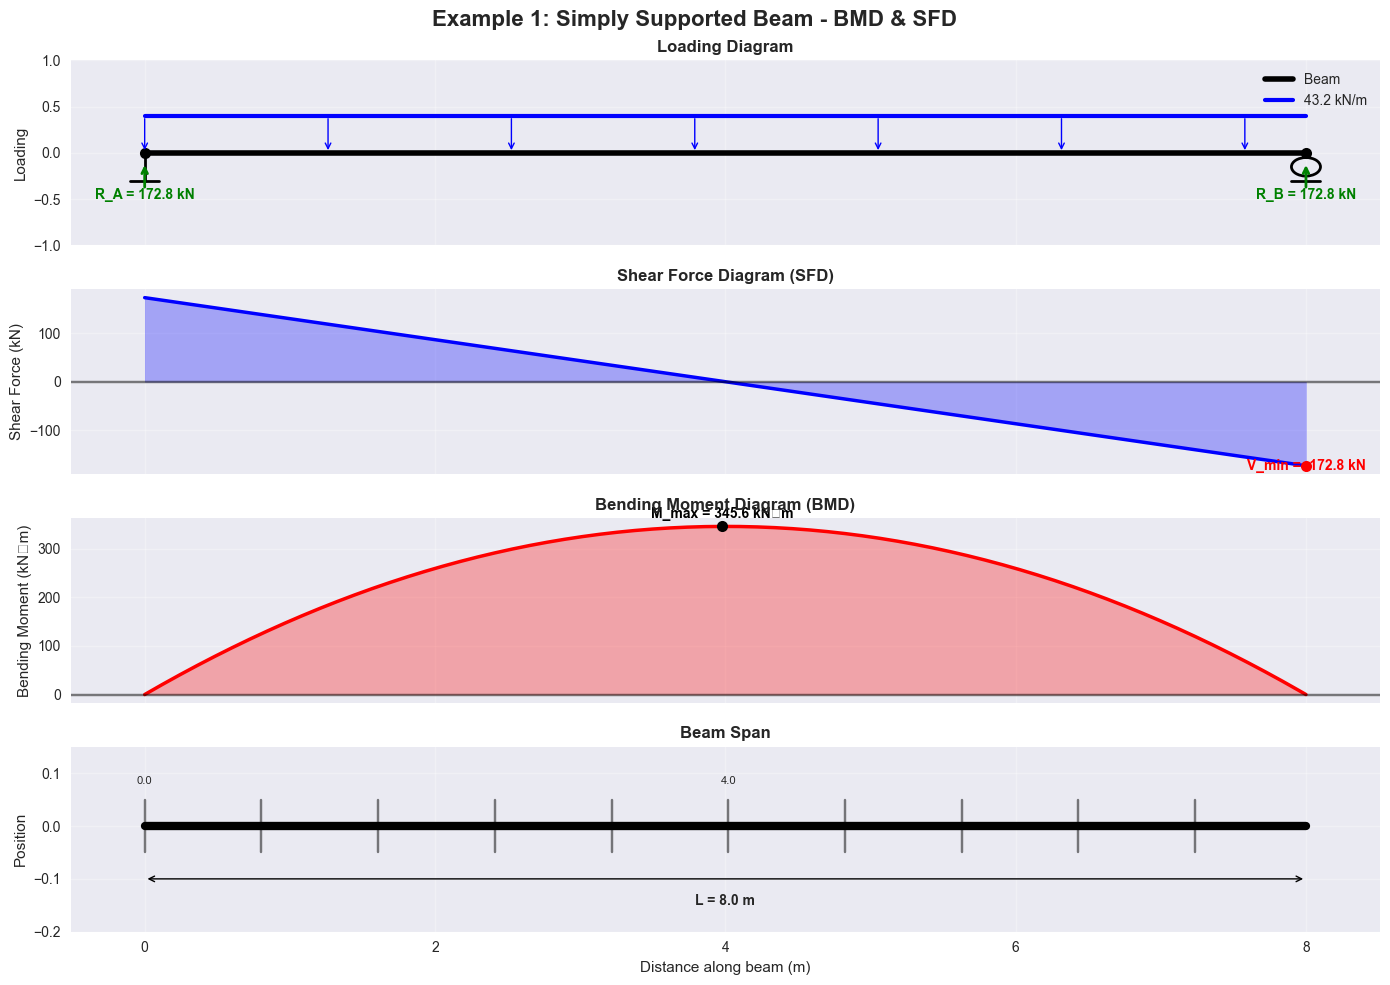

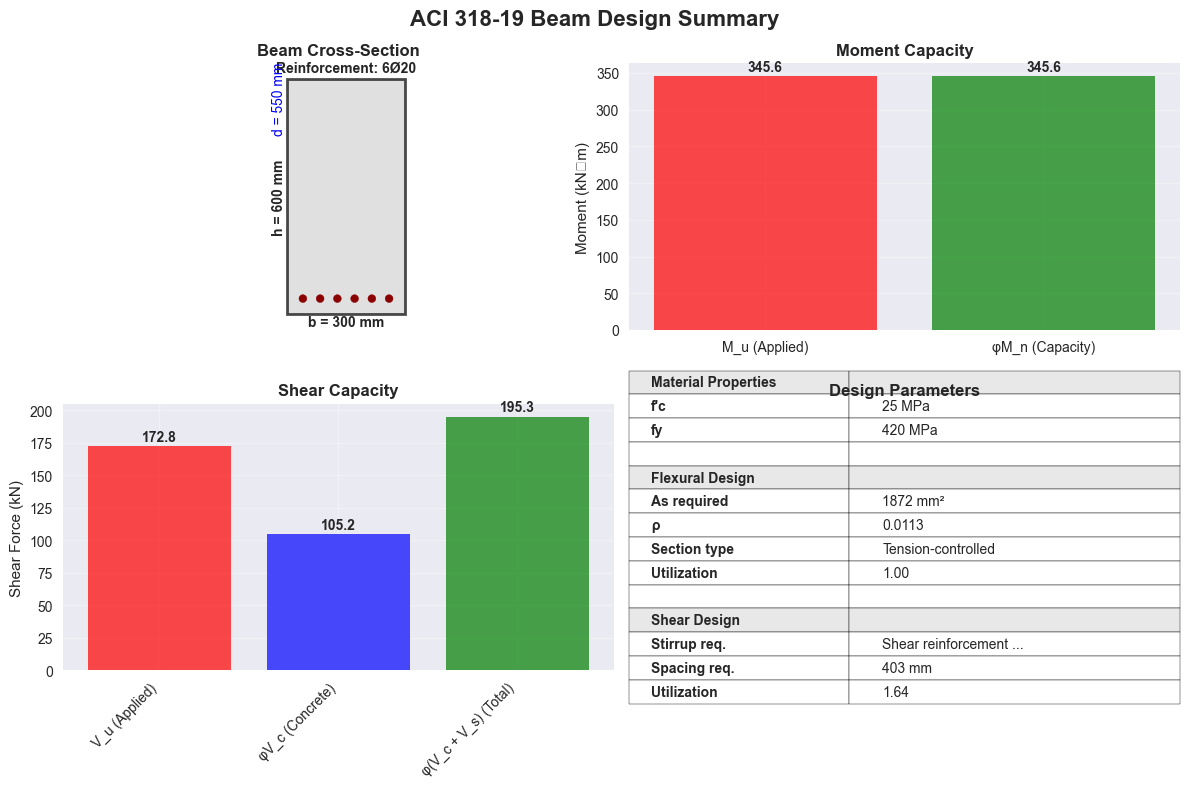

✅ Visualization complete!


In [6]:
# Create visualization for Example 1
print("Creating visualization for Example 1...")

# Plot beam diagrams
fig1 = BeamPlotter.plot_beam_diagrams(beam, title="Example 1: Simply Supported Beam - BMD & SFD")
plt.show()

# Plot design summary
fig2 = BeamPlotter.plot_design_summary(designer, flexural_results, shear_results)
plt.show()

print("✅ Visualization complete!")


In [7]:
# Example 2: Beam with Point Loads

print("=" * 60)
print("EXAMPLE 2: BEAM WITH POINT LOADS")
print("=" * 60)

# Define beam parameters
L2 = 6.0  # Span (m)
P1 = 50.0  # First point load (kN)
P2 = 75.0  # Second point load (kN)
a1 = 2.0   # Position of first load (m)
a2 = 4.5   # Position of second load (m)
w_dead2 = 8.0  # Distributed dead load (kN/m)
fc_prime2 = 30  # Concrete strength (MPa)
fy2 = 420  # Steel yield strength (MPa)
b2 = 250  # Beam width (mm)
h2 = 500  # Beam height (mm)

print(f"Beam Parameters:")
print(f"- Span (L): {L2} m")
print(f"- Point load 1: P1 = {P1} kN at {a1} m from left")
print(f"- Point load 2: P2 = {P2} kN at {a2} m from left")
print(f"- Distributed load: w = {w_dead2} kN/m")
print(f"- Concrete strength (f'c): {fc_prime2} MPa")
print(f"- Steel yield strength (fy): {fy2} MPa")
print(f"- Beam dimensions: {b2} mm × {h2} mm")
print()

# Step 1: Load Analysis with Load Factors
print("STEP 1: LOAD ANALYSIS")
print("-" * 30)

# Apply load factors (assuming point loads are live loads)
P1_factored = ACIConstants.GAMMA_L * P1
P2_factored = ACIConstants.GAMMA_L * P2
w_factored2 = ACIConstants.GAMMA_D * w_dead2

print(f"Factored loads:")
print(f"- Factored point load 1: P1_u = {ACIConstants.GAMMA_L}×{P1} = {P1_factored:.1f} kN")
print(f"- Factored point load 2: P2_u = {ACIConstants.GAMMA_L}×{P2} = {P2_factored:.1f} kN")
print(f"- Factored distributed load: w_u = {ACIConstants.GAMMA_D}×{w_dead2} = {w_factored2:.1f} kN/m")
print()

# Step 2: Create Beam Analysis Model
print("STEP 2: STRUCTURAL ANALYSIS")
print("-" * 30)

# Create beam analyzer
beam2 = BeamAnalyzer(length=L2, supports='simply_supported')
beam2.add_point_load(magnitude=P1_factored, position=a1)
beam2.add_point_load(magnitude=P2_factored, position=a2)
beam2.add_distributed_load(magnitude=w_factored2, start=0, end=L2)

# Calculate reactions
reactions2 = beam2.calculate_reactions()
print(f"Support reactions:")
print(f"- R_A = {reactions2['R_A']:.1f} kN")
print(f"- R_B = {reactions2['R_B']:.1f} kN")

# Verify equilibrium
total_load = P1_factored + P2_factored + w_factored2 * L2
print(f"- Check: R_A + R_B = {reactions2['R_A'] + reactions2['R_B']:.1f} kN")
print(f"- Total applied load = {total_load:.1f} kN")
print()

# Find maximum moment and shear
x_points = np.linspace(0, L2, 200)
moments = [beam2.calculate_bending_moment(x) for x in x_points]
shears = [beam2.calculate_shear_force(x) for x in x_points]

M_max2 = max(moments)
V_max2 = max(abs(s) for s in shears)
x_max_moment = x_points[moments.index(M_max2)]

print(f"Critical values:")
print(f"- Maximum moment: M_u = {M_max2:.1f} kN⋅m at x = {x_max_moment:.2f} m")
print(f"- Maximum shear: V_u = {V_max2:.1f} kN")
print()

# Step 3: Concrete Design
print("STEP 3: CONCRETE BEAM DESIGN")
print("-" * 30)

# Create designer
designer2 = ACIBeamDesigner(fc_prime=fc_prime2, fy=fy2, beam_width=b2, beam_height=h2)

print(f"Beam properties:")
print(f"- Effective depth (d): {designer2.d:.0f} mm")
print(f"- β₁ factor: {designer2.beta1:.3f}")
print(f"- Concrete modulus (Ec): {designer2.ec:.0f} MPa")
print()

# Flexural design
print("3a. Flexural Design:")
flexural_results2 = designer2.design_flexural_reinforcement(M_max2)

print(f"- Required steel area: As = {flexural_results2['As_required']:.0f} mm²")
print(f"- Minimum steel area: As,min = {flexural_results2['As_min']:.0f} mm²")
print(f"- Reinforcement ratio: ρ = {flexural_results2['rho']:.4f}")
print(f"- Section type: {flexural_results2['section_type']}")
print(f"- Moment capacity: φMn = {flexural_results2['phi_Mn']:.1f} kN⋅m")
print(f"- Utilization ratio: {flexural_results2['utilization']:.2f}")
print()

# Select reinforcement bars
bar_options2 = designer2.select_reinforcement_bars(flexural_results2['As_required'])
print("Reinforcement options:")
for i, option in enumerate(bar_options2[:3]):
    print(f"  {i+1}. {option['bars']} (Area: {option['area_provided']:.0f} mm², "
          f"Ratio: {option['area_ratio']:.2f})")
print()

# Shear design
print("3b. Shear Design:")
shear_results2 = designer2.design_shear_reinforcement(V_max2)

print(f"- Concrete shear capacity: φVc = {shear_results2['phi_Vc']:.1f} kN")
print(f"- Required steel shear capacity: Vs = {shear_results2['Vs_required']:.1f} kN")
print(f"- Stirrup requirement: {shear_results2['stirrup_requirement']}")
print(f"- Required stirrup spacing: s = {shear_results2['s_required']:.0f} mm")
print(f"- Shear utilization ratio: {shear_results2['utilization']:.2f}")
print()

# Step 4: Final Design Summary
print("STEP 4: FINAL DESIGN SUMMARY")
print("-" * 30)
best_reinforcement2 = bar_options2[0] if bar_options2 else None

print(f"Final Design:")
print(f"- Beam dimensions: {b2} mm × {h2} mm")
print(f"- Concrete: f'c = {fc_prime2} MPa")
print(f"- Steel: fy = {fy2} MPa")

if best_reinforcement2:
    print(f"- Main reinforcement: {best_reinforcement2['bars']}")
    print(f"- Provided area: {best_reinforcement2['area_provided']:.0f} mm²")

if shear_results2['Vs_required'] > 0:
    print(f"- Stirrups: Ø10 @ {min(shear_results2['s_required'], shear_results2['s_max']):.0f} mm c/c")
else:
    print(f"- Stirrups: Ø10 @ {shear_results2['s_max']:.0f} mm c/c (minimum)")

# Check design adequacy
if flexural_results2['utilization'] <= 1.0 and shear_results2['utilization'] <= 1.0:
    print("\n✅ Design is ADEQUATE!")
else:
    print("\n❌ Design is NOT adequate - increase beam dimensions!")

print("\n" + "=" * 60)


EXAMPLE 2: BEAM WITH POINT LOADS
Beam Parameters:
- Span (L): 6.0 m
- Point load 1: P1 = 50.0 kN at 2.0 m from left
- Point load 2: P2 = 75.0 kN at 4.5 m from left
- Distributed load: w = 8.0 kN/m
- Concrete strength (f'c): 30 MPa
- Steel yield strength (fy): 420 MPa
- Beam dimensions: 250 mm × 500 mm

STEP 1: LOAD ANALYSIS
------------------------------
Factored loads:
- Factored point load 1: P1_u = 1.6×50.0 = 80.0 kN
- Factored point load 2: P2_u = 1.6×75.0 = 120.0 kN
- Factored distributed load: w_u = 1.2×8.0 = 9.6 kN/m

STEP 2: STRUCTURAL ANALYSIS
------------------------------
Support reactions:
- R_A = 112.1 kN
- R_B = 145.5 kN
- Check: R_A + R_B = 257.6 kN
- Total applied load = 257.6 kN

Critical values:
- Maximum moment: M_u = 213.8 kN⋅m at x = 3.35 m
- Maximum shear: V_u = 145.5 kN

STEP 3: CONCRETE BEAM DESIGN
------------------------------
Beam properties:
- Effective depth (d): 450 mm
- β₁ factor: 0.836
- Concrete modulus (Ec): 25743 MPa

3a. Flexural Design:
- Required s

Creating visualization for Example 2...


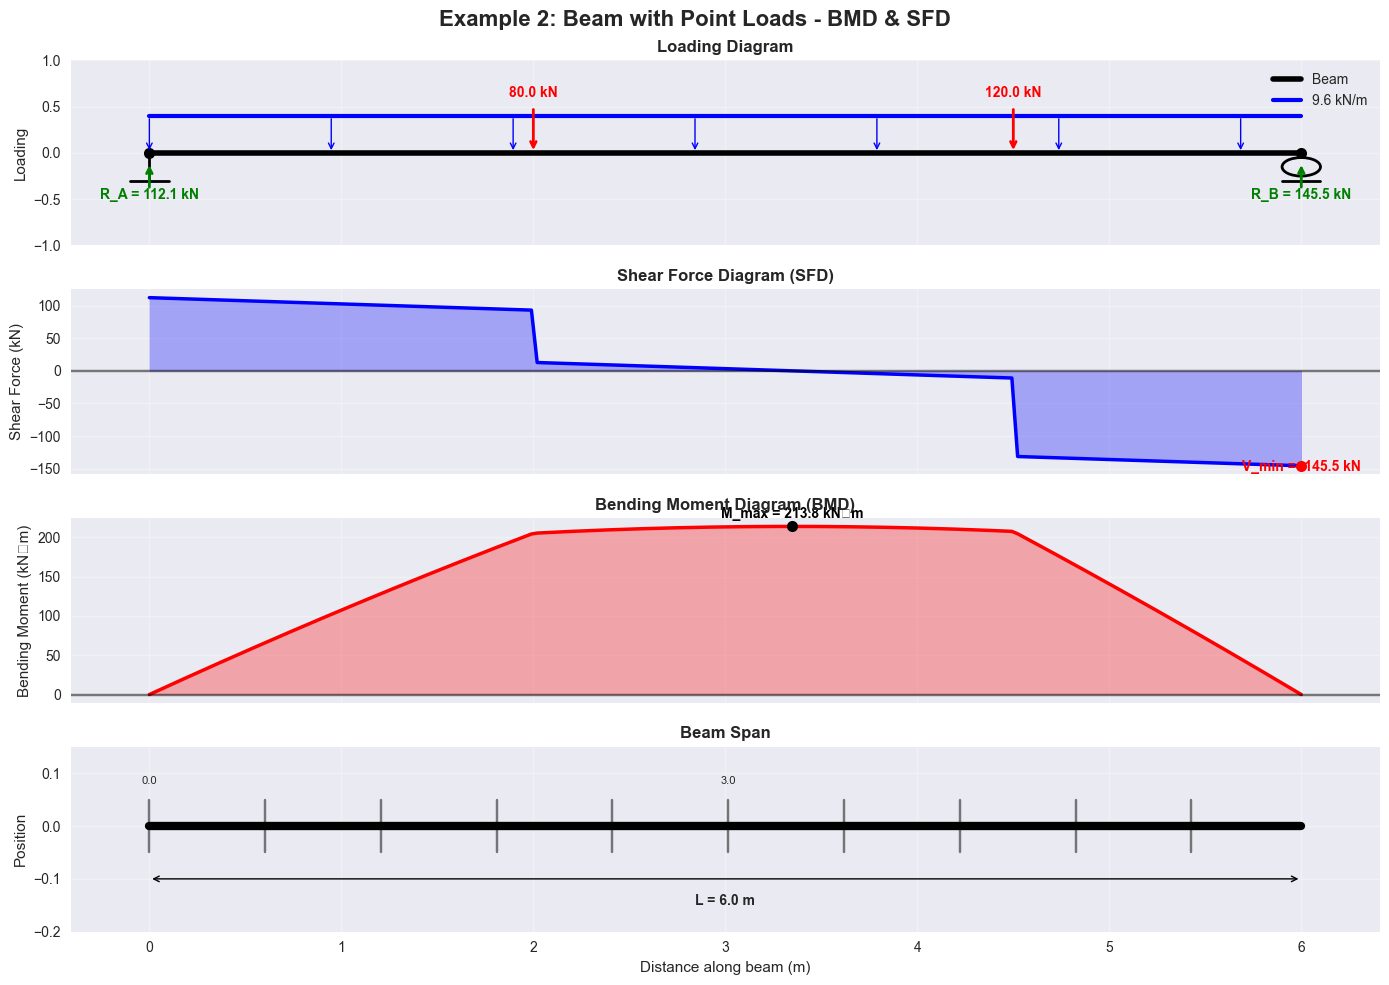

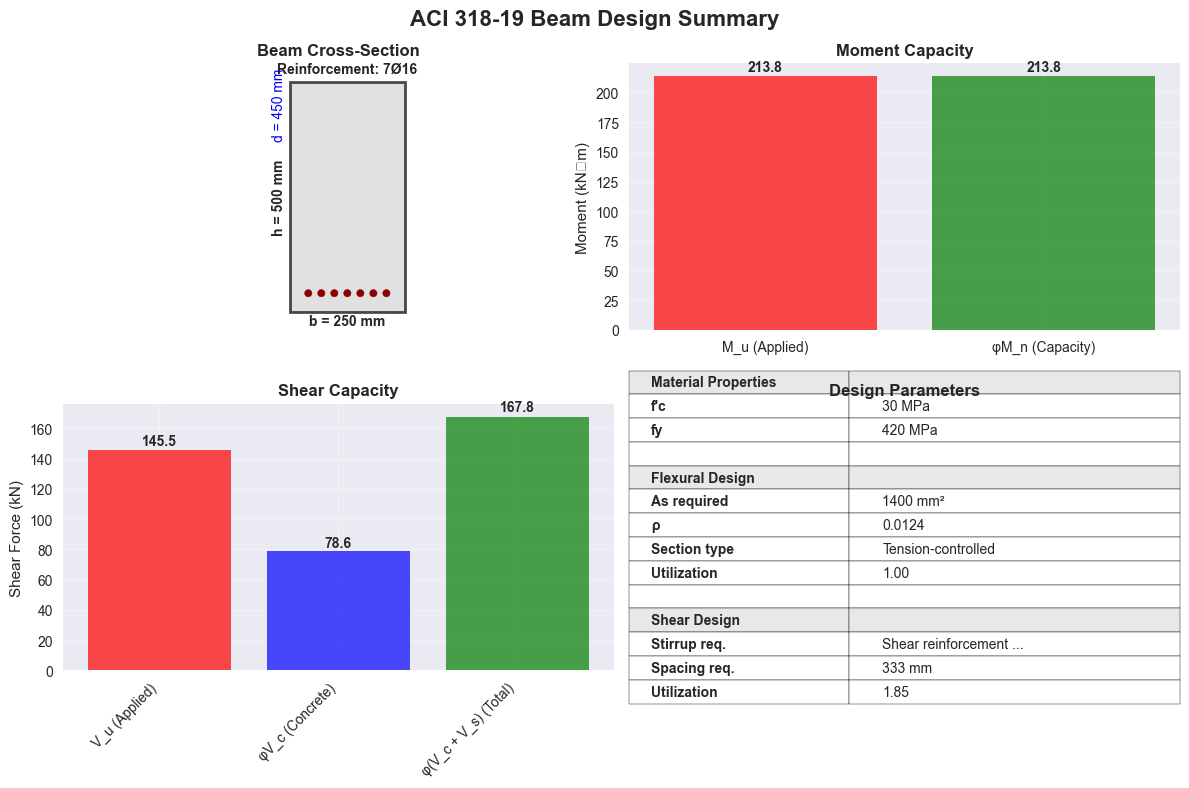

✅ Visualization complete!


In [8]:
# Create visualization for Example 2
print("Creating visualization for Example 2...")

# Plot beam diagrams
fig3 = BeamPlotter.plot_beam_diagrams(beam2, title="Example 2: Beam with Point Loads - BMD & SFD")
plt.show()

# Plot design summary
fig4 = BeamPlotter.plot_design_summary(designer2, flexural_results2, shear_results2)
plt.show()

print("✅ Visualization complete!")


In [ ]:
def interactive_beam_designer(span=8.0, dead_load=15.0, live_load=20.0, 
                             fc_prime=25, fy=420, beam_width=300, beam_height=600):
    """
    Interactive beam design function - modify parameters to see results
    
    Parameters:
    -----------
    span : float
        Beam span in meters
    dead_load : float
        Dead load in kN/m
    live_load : float  
        Live load in kN/m
    fc_prime : float
        Concrete compressive strength in MPa
    fy : float
        Steel yield strength in MPa
    beam_width : float
        Beam width in mm
    beam_height : float
        Beam height in mm
    """
    
    print("🏗️ INTERACTIVE BEAM DESIGNER 🏗️")
    print("=" * 50)
    
    # Create beam and designer
    w_factored = ACIConstants.GAMMA_D * dead_load + ACIConstants.GAMMA_L * live_load
    
    beam = BeamAnalyzer(length=span, supports='simply_supported')
    beam.add_distributed_load(magnitude=w_factored, start=0, end=span)
    
    designer = ACIBeamDesigner(fc_prime=fc_prime, fy=fy, 
                              beam_width=beam_width, beam_height=beam_height)
    
    # Calculate critical forces
    M_max = w_factored * span**2 / 8
    V_max = w_factored * span / 2
    
    # Design
    flexural_results = designer.design_flexural_reinforcement(M_max)
    shear_results = designer.design_shear_reinforcement(V_max)
    bar_options = designer.select_reinforcement_bars(flexural_results['As_required'])
    
    # Display results
    print(f"Input Parameters:")
    print(f"- Span: {span} m")
    print(f"- Dead load: {dead_load} kN/m")
    print(f"- Live load: {live_load} kN/m")
    print(f"- f'c: {fc_prime} MPa")
    print(f"- fy: {fy} MPa")
    print(f"- Beam: {beam_width} × {beam_height} mm")
    print()
    
    print(f"Analysis Results:")
    print(f"- Factored load: {w_factored:.1f} kN/m")
    print(f"- Max moment: {M_max:.1f} kN⋅m")
    print(f"- Max shear: {V_max:.1f} kN")
    print()
    
    print(f"Design Results:")
    print(f"- Required As: {flexural_results['As_required']:.0f} mm²")
    print(f"- Moment utilization: {flexural_results['utilization']:.2f}")
    print(f"- Shear utilization: {shear_results['utilization']:.2f}")
    
    if bar_options:
        print(f"- Recommended reinforcement: {bar_options[0]['bars']}")
    
    # Design status
    if flexural_results['utilization'] <= 1.0 and shear_results['utilization'] <= 1.0:
        print("✅ Design Status: ADEQUATE")
    else:
        print("❌ Design Status: NOT ADEQUATE - Increase beam size")
    
    print("\n" + "=" * 50)
    
    return beam, designer, flexural_results, shear_results

# Example usage - modify these parameters to test different designs
print("Example: Testing different beam configurations")
print()

# Test 1: Original design
print("Test 1: Original parameters")
beam_test1, designer_test1, flex_test1, shear_test1 = interactive_beam_designer()

# Test 2: Higher loads
print("\nTest 2: Higher loads")
beam_test2, designer_test2, flex_test2, shear_test2 = interactive_beam_designer(
    dead_load=20.0, live_load=30.0)

# Test 3: Larger beam
print("\nTest 3: Larger beam dimensions")
beam_test3, designer_test3, flex_test3, shear_test3 = interactive_beam_designer(
    dead_load=20.0, live_load=30.0, beam_width=350, beam_height=700)
